In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [3]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

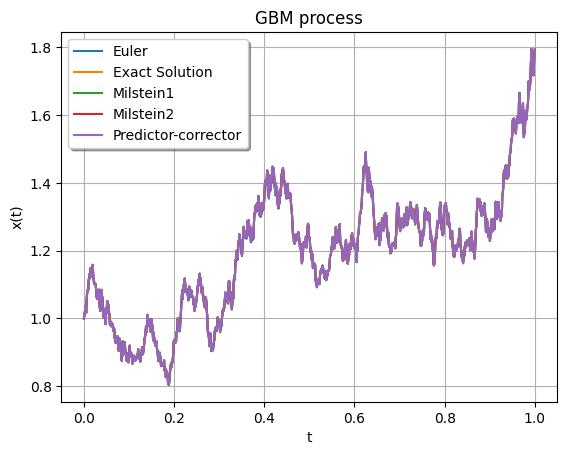

In [4]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [3]:
# Define levels of discretization
N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
T = 1
Nx = 1
x0 = 1
init_state = x0 * np.ones(Nx)

theta1 = 2
theta2 = 0.5
params = [theta1, theta2]

# Store maximum absolute differences for each method
results = {"Euler": [], "Milstein1": [], "Milstein2": [], "PredictorCorrector": []}

for Nt in N_values:
    dt = T / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

    # Initialize BSM process
    BSMp = BSMprocess(params, T, Nx, Nt, init_state)

    # Exact solution
    _, exact_solution = BSMp.ExactSolution(dwt)

    # Euler approximation
    _, euler_solution = BSMp.EulerSolution(dwt)
    euler_diff = np.max(np.abs(exact_solution - euler_solution))
    results["Euler"].append(euler_diff)

    # Milstein 1 approximation
    _, milstein1_solution = BSMp.Milstein1Solution(dwt)
    milstein1_diff = np.max(np.abs(exact_solution - milstein1_solution))
    results["Milstein1"].append(milstein1_diff)

    # Milstein 2 approximation
    _, milstein2_solution = BSMp.Milstein2Solution(dwt)
    milstein2_diff = np.max(np.abs(exact_solution - milstein2_solution))
    results["Milstein2"].append(milstein2_diff)

    # Predictor-Corrector approximation
    _, predictor_corrector_solution = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
    predictor_corrector_diff = np.max(np.abs(exact_solution - predictor_corrector_solution))
    results["PredictorCorrector"].append(predictor_corrector_diff)

# Display the results as a table
print("Maximum Absolute Difference for Different Methods and Levels of Discretization")
print(f"{'N':>10} {'Euler':>15} {'Milstein1':>15} {'Milstein2':>15} {'PredictorCorrector':>20}")
for i, Nt in enumerate(N_values):
    print(f"{Nt:>10} {results['Euler'][i]:>15.10f} {results['Milstein1'][i]:>15.10f} {results['Milstein2'][i]:>15.10f} {results['PredictorCorrector'][i]:>20.10f}")


Maximum Absolute Difference for Different Methods and Levels of Discretization
         N           Euler       Milstein1       Milstein2   PredictorCorrector
         2    3.4561634767    3.4411751983    1.1171333646         1.2783452254
         4    0.7828726091    0.8174976178    0.0630595907         0.1361100276
         8    2.5296859505    2.5472052720    0.3067809690         0.4441905331
       128    0.6696377267    0.5508741788    0.0026086802         0.0241870751
       256    0.0762834807    0.0149049139    0.0008058752         0.0011140672
       512    0.0656587591    0.0178803455    0.0004928039         0.0008978417
      1024    0.0422218880    0.0079521102    0.0002431483         0.0004213818
      8192    0.0046101581    0.0005163823    0.0000494496         0.0000995371
     16384    0.0091311597    0.0007677335    0.0000175037         0.0000628807
     32768    0.0016810058    0.0000364525    0.0000049574         0.0000103845


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



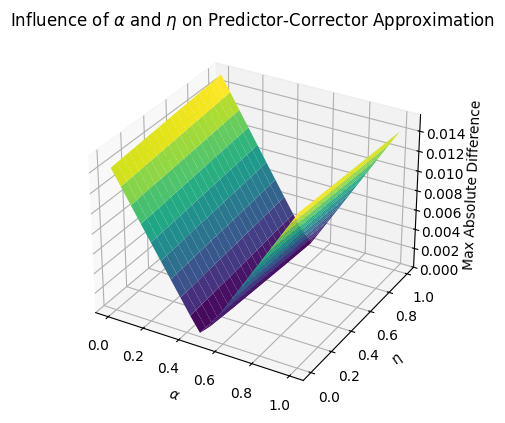

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Define the parameters for the study
T = 1
Nx = 1
Nt = 1024
x0 = 1
init_state = x0 * np.ones(Nx)

theta1 = 2
theta2 = 0.5
params = [theta1, theta2]

# Define range of alpha and eta values
alpha_values = np.linspace(0, 1, 20)  # 20 values between 0 and 1
eta_values = np.linspace(0, 1, 20)    # 20 values between 0 and 1

# Prepare arrays to store results
alpha_grid, eta_grid = np.meshgrid(alpha_values, eta_values)
max_abs_diff = np.zeros_like(alpha_grid)

# Generate random Wiener process
dt = T / Nt
dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

# Initialize the BSM process
BSMp = BSMprocess(params, T, Nx, Nt, init_state)

# Exact solution for comparison
_, exact_solution = BSMp.ExactSolution(dwt)

# Loop over all combinations of alpha and eta
for i, alpha in enumerate(alpha_values):
    for j, eta in enumerate(eta_values):
        # Predictor-Corrector approximation for each (alpha, eta)
        _, pred_corr_solution = BSMp.PredictorCorrectorSolution(dwt, alpha, eta)
        
        # Compute maximum absolute difference
        max_abs_diff[j, i] = np.max(np.abs(exact_solution - pred_corr_solution))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_surface(alpha_grid, eta_grid, max_abs_diff, cmap='viridis')

# Labels and title with raw strings to avoid LaTeX escape issues
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel('Max Absolute Difference')
ax.set_title(r'Influence of $\alpha$ and $\eta$ on Predictor-Corrector Approximation')

plt.show()

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

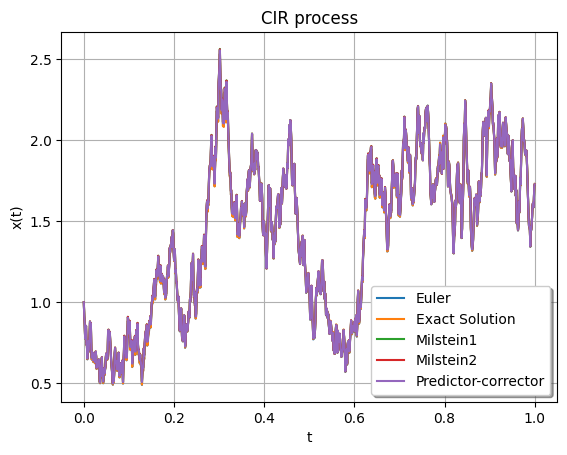

In [7]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

C:\Users\Mirom\AppData\Local\Temp\ipykernel_7672\4085498755.py:188: RuntimeWarning: divide by zero encountered in divide
  self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
C:\Users\Mirom\AppData\Local\Temp\ipykernel_7672\4085498755.py:80: RuntimeWarning: invalid value encountered in multiply
  1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
C:\Users\Mirom\AppData\Local\Temp\ipykernel_7672\4085498755.py:114: RuntimeWarning: invalid value encountered in multiply
  bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)


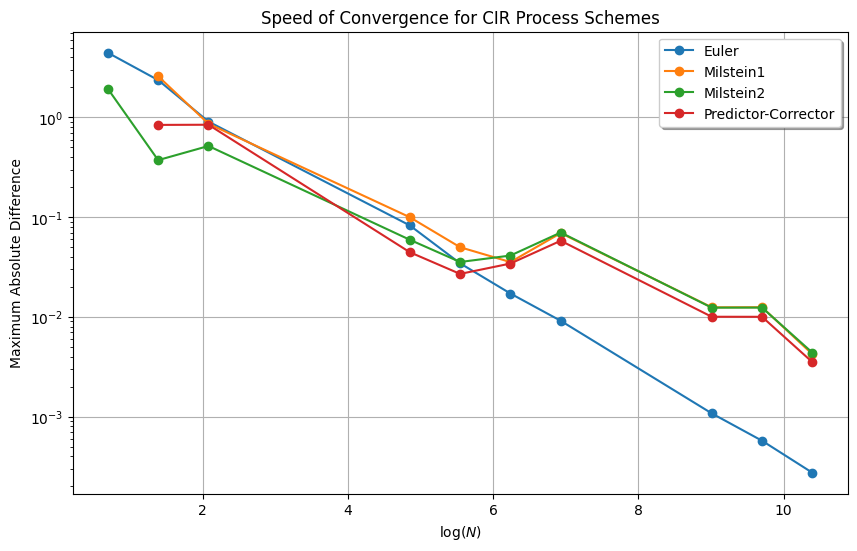

In [8]:
# Define parameters for the CIR process
T = 1
Nx = 1
theta1 = 6
theta2 = 3
theta3 = 2
init_state = np.array([10])

params = [theta1, theta2, theta3]

# Define the number of discretization levels to check
N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
max_abs_diffs = { 'Euler': [], 'Milstein1': [], 'Milstein2': [], 'Predictor-Corrector': [] }

for N in N_values:
    Nt = N
    dt = T / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
    
    # Initialize the CIR process
    CIRp = CIRprocess(params, T, Nx, Nt, init_state)
    
    # Compute exact solution for comparison
    _, exact_solution = CIRp.ExactSolution(dwt)
    
    # Euler approximation
    _, euler_solution = CIRp.EulerSolution(dwt)
    max_abs_diffs['Euler'].append(np.max(np.abs(exact_solution - euler_solution)))
    
    # Milstein 1st order approximation
    _, milstein1_solution = CIRp.Milstein1Solution(dwt)
    max_abs_diffs['Milstein1'].append(np.max(np.abs(exact_solution - milstein1_solution)))
    
    # Milstein 2nd order approximation
    _, milstein2_solution = CIRp.Milstein2Solution(dwt)
    max_abs_diffs['Milstein2'].append(np.max(np.abs(exact_solution - milstein2_solution)))
    
    # Predictor-Corrector approximation with default alpha and eta
    alpha, eta = 0.4, 0.6
    _, pred_corr_solution = CIRp.PredictorCorrectorSolution(dwt, alpha, eta)
    max_abs_diffs['Predictor-Corrector'].append(np.max(np.abs(exact_solution - pred_corr_solution)))

# Plotting
plt.figure(figsize=(10, 6))
for scheme, diffs in max_abs_diffs.items():
    plt.plot(np.log(N_values), diffs, marker='o', label=scheme)

plt.title('Speed of Convergence for CIR Process Schemes')
plt.xlabel(r'$\log(N)$')
plt.ylabel('Maximum Absolute Difference')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for y-axis
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [ ]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

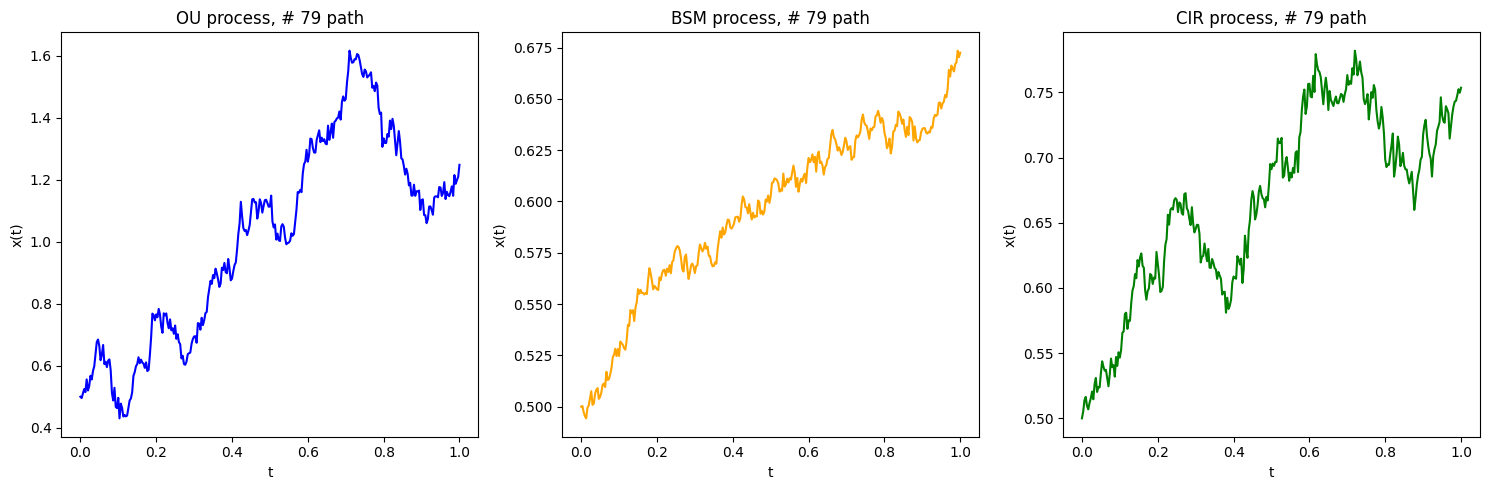

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

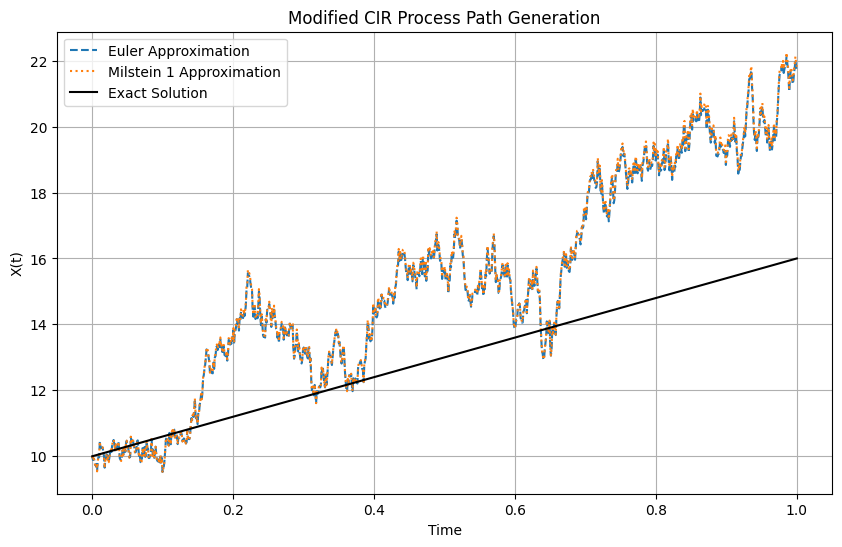

In [9]:
class ModifiedCIRProcess:
    def __init__(self, params, T, Nx, Nt, init_state):
        self.theta1, self.theta2 = params  # Unpack parameters
        self.T = T  # Total time
        self.Nx = Nx  # Number of processes (1 for univariate)
        self.Nt = Nt  # Number of time steps
        self.init_state = init_state  # Initial state
        self.dt = T / Nt  # Time step

    def EulerSolution(self, dW):
        X = np.zeros((self.Nt, self.Nx))
        X[0] = self.init_state

        for t in range(1, self.Nt):
            X[t] = X[t - 1] + self.theta1 * self.dt + self.theta2 * np.sqrt(X[t - 1]) * dW[t - 1]
            # Ensure positivity
            X[t] = max(X[t], 0)
        
        return np.linspace(0, self.T, self.Nt), X

    def Milstein1Solution(self, dW):
        X = np.zeros((self.Nt, self.Nx))
        X[0] = self.init_state

        for t in range(1, self.Nt):
            X[t] = X[t - 1] + self.theta1 * self.dt + self.theta2 * np.sqrt(X[t - 1]) * dW[t - 1]
            # Milstein correction term
            X[t] += 0.5 * self.theta2 * dW[t - 1] * (1 / (2 * np.sqrt(X[t - 1])) if X[t - 1] > 0 else 0)
            # Ensure positivity
            X[t] = max(X[t], 0)

        return np.linspace(0, self.T, self.Nt), X

    def ExactSolution(self, dW):
        # This method should compute the exact solution if available
        # Here we'll use a placeholder since exact solutions may not be trivial
        t = np.linspace(0, self.T, self.Nt)
        X_exact = np.maximum(0, self.init_state + self.theta1 * t)  # Placeholder for exact solution
        return t, X_exact

# Example usage
T = 1  # Total time
Nx = 1  # Number of processes
Nt = 1024  # Number of time steps
init_state = np.array([10])  # Initial state
params = [6, 2]  # Example parameters for the modified CIR model

# Generate random increments for Wiener process
dW = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt)

# Create an instance of the ModifiedCIRProcess
cir_process = ModifiedCIRProcess(params, T, Nx, Nt, init_state)

# Generate solutions
t_data, x_euler = cir_process.EulerSolution(dW)
t_data, x_milstein1 = cir_process.Milstein1Solution(dW)
t_data, x_exact = cir_process.ExactSolution(dW)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_euler, label='Euler Approximation', linestyle='--')
plt.plot(t_data, x_milstein1, label='Milstein 1 Approximation', linestyle=':')
plt.plot(t_data, x_exact, label='Exact Solution', color='black')

plt.title('Modified CIR Process Path Generation')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

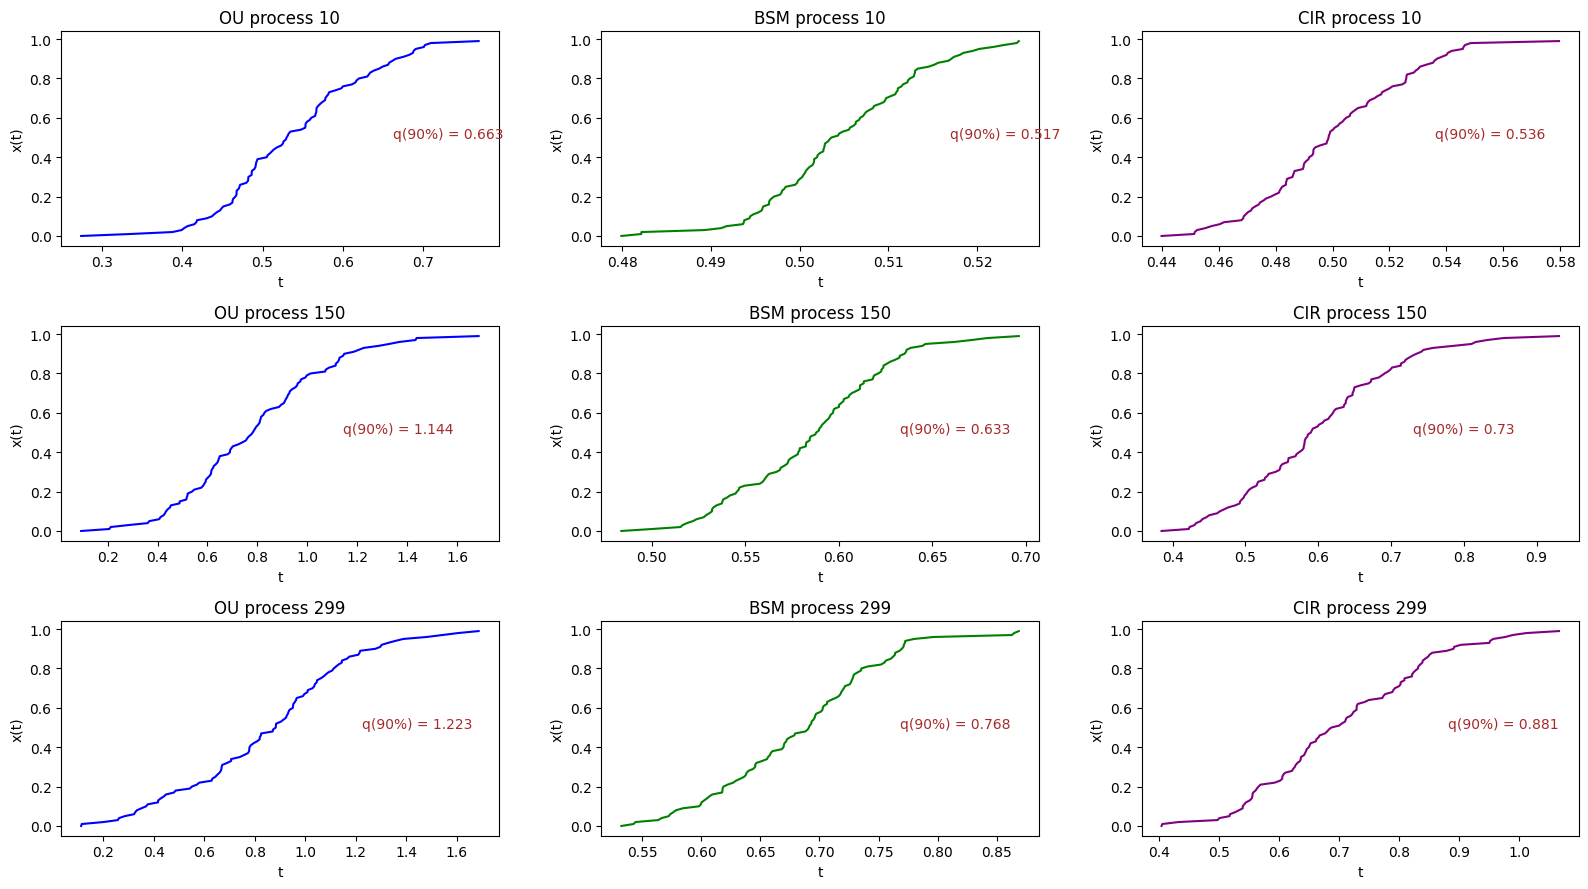

In [ ]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

KS Statistic: [0.0632], P-value: [8.78150154e-18]


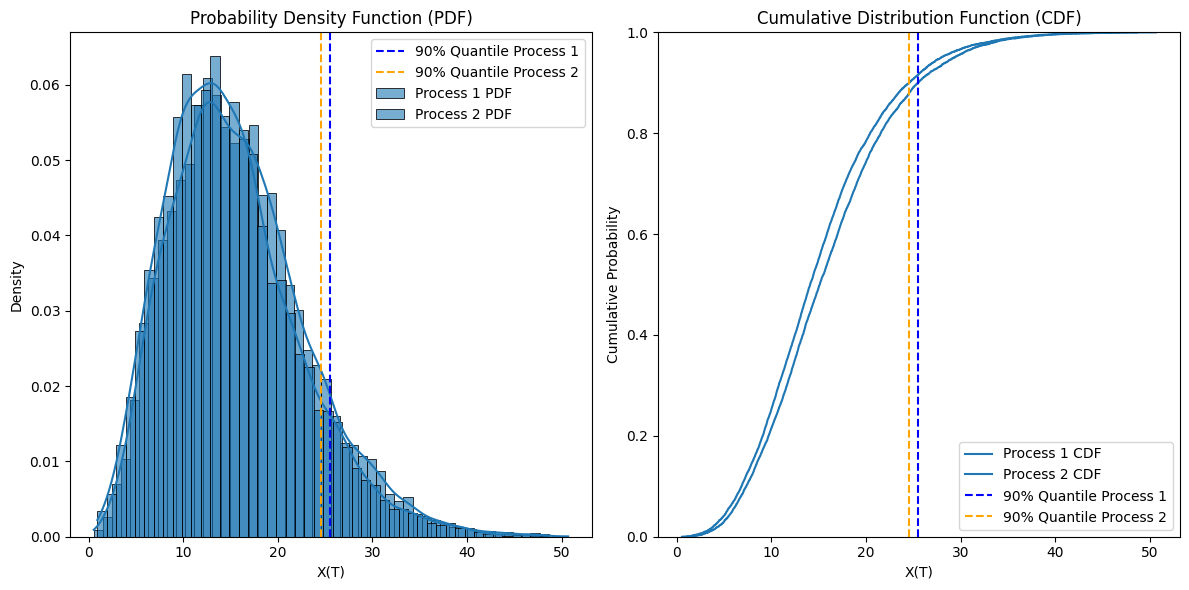

The two samples are significantly different (reject H0).


In [11]:
import seaborn as sns
from scipy import stats
# Define the ModifiedCIRProcess class as previously implemented
class ModifiedCIRProcess:
    def __init__(self, params, T, Nx, Nt, init_state):
        self.theta1, self.theta2 = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state
        self.dt = T / Nt

    def EulerSolution(self, dW):
        X = np.zeros((self.Nt, self.Nx))
        X[0] = self.init_state

        for t in range(1, self.Nt):
            X[t] = X[t - 1] + self.theta1 * self.dt + self.theta2 * np.sqrt(X[t - 1]) * dW[t - 1]
            # Ensure positivity
            X[t] = max(X[t], 0)

        return X[-1]  # Return the final value

# Simulation settings
T = 1  # Total time
Nx = 1  # Number of processes
Nt = 1024  # Number of time steps
init_state = np.array([10])  # Initial state

# Parameters for two processes
params1 = [6, 2]  # First set of parameters
params2 = [5, 2]  # Second set of parameters (slightly different)

# Number of paths to simulate
num_paths = 10000

# Store final values for two samples
final_values1 = []
final_values2 = []

# Simulate paths for first process
for _ in range(num_paths):
    dW = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt)
    cir_process1 = ModifiedCIRProcess(params1, T, Nx, Nt, init_state)
    final_value1 = cir_process1.EulerSolution(dW)
    final_values1.append(final_value1)

# Simulate paths for second process
for _ in range(num_paths):
    dW = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt)
    cir_process2 = ModifiedCIRProcess(params2, T, Nx, Nt, init_state)
    final_value2 = cir_process2.EulerSolution(dW)
    final_values2.append(final_value2)

# Convert to numpy arrays
final_values1 = np.array(final_values1)
final_values2 = np.array(final_values2)

# Calculate the K-S test statistic and p-value
ks_statistic, p_value = stats.ks_2samp(final_values1, final_values2)
print(f"KS Statistic: {ks_statistic}, P-value: {p_value}")

# Calculate 90% quantiles for both samples
quantile_90_1 = np.percentile(final_values1, 90)
quantile_90_2 = np.percentile(final_values2, 90)

# Plot PDF and CDF for both samples
plt.figure(figsize=(12, 6))

# Plot PDF
plt.subplot(1, 2, 1)
sns.histplot(final_values1, bins=50, kde=True, stat="density", label='Process 1 PDF', color='blue', alpha=0.6)
sns.histplot(final_values2, bins=50, kde=True, stat="density", label='Process 2 PDF', color='orange', alpha=0.6)
plt.axvline(quantile_90_1, color='blue', linestyle='--', label='90% Quantile Process 1')
plt.axvline(quantile_90_2, color='orange', linestyle='--', label='90% Quantile Process 2')
plt.title('Probability Density Function (PDF)')
plt.xlabel('X(T)')
plt.ylabel('Density')
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
sns.ecdfplot(final_values1, label='Process 1 CDF', color='blue')
sns.ecdfplot(final_values2, label='Process 2 CDF', color='orange')
plt.axvline(quantile_90_1, color='blue', linestyle='--', label='90% Quantile Process 1')
plt.axvline(quantile_90_2, color='orange', linestyle='--', label='90% Quantile Process 2')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('X(T)')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusions based on the K-S test
if p_value < 0.05:
    print("The two samples are significantly different (reject H0).")
else:
    print("The two samples are not significantly different (fail to reject H0).")

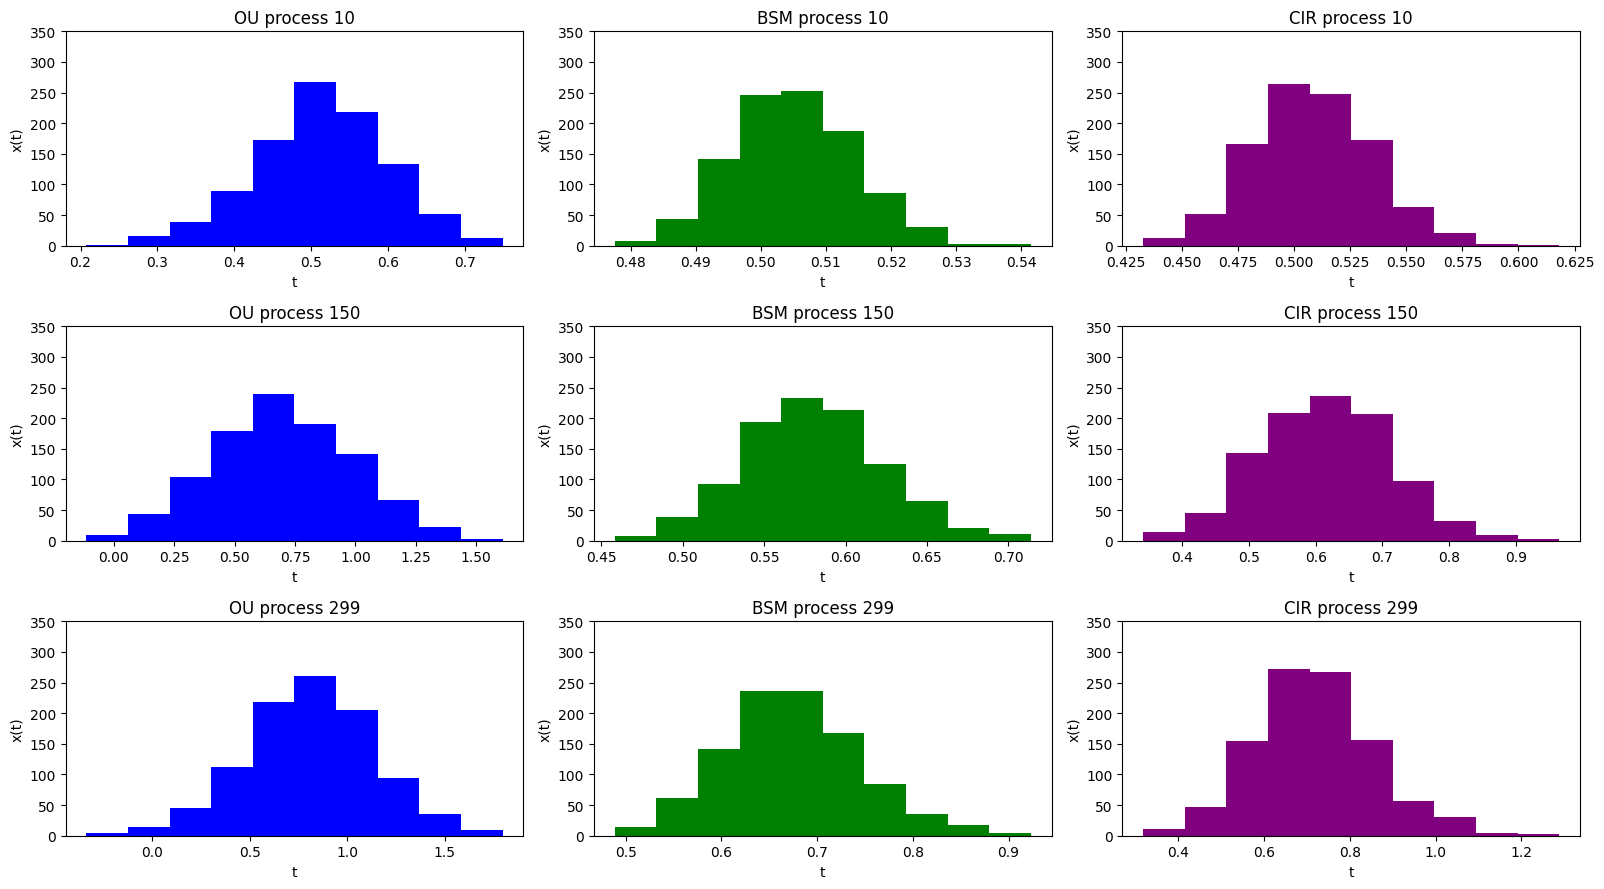

In [ ]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

In [12]:
from scipy import stats

# Assume x_data_OU, x_data_BSM, and x_data_CIR are already generated and available

# Function to perform normality tests and plot histograms
def normality_tests_and_plot(data, process_name, n):
    # Perform Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    
    # Perform Anderson-Darling test
    ad_stat, ad_crit, ad_signif = stats.anderson(data)
    
    # Print test results
    print(f"Normality Test Results for {process_name} at time index {n}:")
    print(f"  Shapiro-Wilk: Statistic={shapiro_stat}, P-value={shapiro_p}")
    print(f"  Anderson-Darling: Statistic={ad_stat}, Critical Values={ad_crit}, Significance Levels={ad_signif}")
    
    # Plot histogram and overlay normal distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(data, kde=True, color='blue', stat='density', bins=30)
    mu, std = np.mean(data), np.std(data)
    xmin, xmax = plt.xlim()
    
    # Create a range of values for the normal distribution
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    plt.title(f'Histogram and Normal Distribution Overlay for {process_name} at time index {n}')
    plt.xlabel('x(t)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Choose time indices to analyze
time_indices = [0, Nt // 2, Nt - 1]

# Perform normality tests and plot for each process
for n in time_indices:
    normality_tests_and_plot(x_data_OU[n], 'OU Process', n)
    normality_tests_and_plot(x_data_BSM[n], 'BSM Process', n)
    normality_tests_and_plot(x_data_CIR[n], 'CIR Process', n)

NameError: name 'x_data_OU' is not defined